this shows that, changing nonlinearity won't make much difference.

notice there there is the loss (deviance, error, whatever you call it) is much different for MATLAB and R.

However, they match when using smaller datasets (check [demo version](./glm_R_vs_lassoglm_MATLAB_demo_data.ipynb)).

I think this is mostly due to R version being more precise than MATLAB verion (convergence, tol, etc.).

For MATLAB version `glmnet_cv_best_result.m` where I have no access to predictions made by each folds, I make them myself. Notice that the per-fold predictions provided by R function is not available to be obtained this way. Check source code <https://github.com/cran/glmnet/blob/2.0-13/R/cv.glmnet.R#L27>. Also <https://github.com/cran/glmnet/blob/2.0-13/ChangeLog#L19>. Basically, the sequence of lambda is chosen using all data, and each fold of data is fitted using their OWN sequence of lambdas. However, predictions on the test (left out) fold is made on the lambda sequence inferred from all data, using some interpolation (see <https://github.com/cran/glmnet/blob/2.0-13/man/predict.glmnet.Rd>, on `exact`). So possibly, the difference in loss can be due to this approximation as well.

Another thing to notice is that the lambda sequence for Poisson and Gaussian are the same in this case (starting from `1.56812570e-02`. Not sure if this holds in general. Check [demo version](./glm_R_vs_lassoglm_MATLAB_demo_data.ipynb), where it holds as well. However, the lambda sequence for softplus is different.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

In [2]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name, end=' ')
        print('Elapsed: %s' % (time.time() - self.tstart))

In [3]:
from tang_jcompneuro_legacy import glm, glm_matlab, glm_matlab_aux

/home/yimengzh_everyday/miniconda2/envs/tf15/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/home/yimengzh_everyday/miniconda2/envs/tf15/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: foreach

  warnings.warn(x, RRuntimeWarning)
/home/yimengzh_everyday/miniconda2/envs/tf15/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loaded glmnet 2.0-13


  warnings.warn(x, RRuntimeWarning)


In [4]:
# load data
from tang_jcompneuro.io import load_split_dataset

In [5]:
datasets = load_split_dataset('MkA_Shape', 'all', False, 553)

In [6]:
X_train, y_train, X_test, y_test = datasets[:4]

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7600, 1, 20, 20), (7600, 1), (1900, 1, 20, 20), (1900, 1))

In [8]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7600, 400), (7600, 1), (1900, 400), (1900, 1))

In [10]:
# perform PCA on Xtrain.
# same thing on X_test.

In [11]:
from sklearn.decomposition import PCA

In [12]:
# random stuff is faster.
pca_obj = PCA(svd_solver='randomized', random_state=0)
pca_obj.fit(X_train)
X_train_pca = pca_obj.transform(X_train)
X_test_pca = pca_obj.transform(X_test)
foldid = glm_matlab.convert_sklearn_kfold_to_glmnet_foldid(7600, 5, seed=0)

In [13]:
X_train_pca.shape, X_test_pca.shape

((7600, 400), (1900, 400))

In [14]:
# # use MATLAB example.
# rng_state = np.random.RandomState(seed=0)
# X = rng_state.randn(1000,20)
# coef = np.zeros(20)
# coef[[4, 9, 14]] = np.array([.4, .2, .3])
# bias = 1
# y_linear = X@coef + bias
# foldid = glm_matlab.convert_sklearn_kfold_to_glmnet_foldid(1000, 5, seed=0)

In [15]:
# # dummy data
# # use MATLAB example.
# rng_state = np.random.RandomState(seed=0)
# X_train_pca = rng_state.randn(1000,5)
# coef = np.zeros(5)
# coef[[1, 3, 4]] = np.array([.4, .2, .3])
# bias = 1
# y_linear = X_train_pca@coef + bias
# y_linear = y_linear[:,np.newaxis]
# y_linear = np.log(np.exp(y_linear) + 1)
# foldid = glm_matlab.convert_sklearn_kfold_to_glmnet_foldid(1000, 5, seed=0)

In [16]:
# first, do Gaussian.
def test_gaussian(X, y):
    with Timer('Gaussian R'):
        fit_R = glm.glmnet_cv(X, y, standardize=False, type_measure='mse',
                            family='gaussian',
                            foldid=foldid, alpha=1.0, keep=True)
        predicted_y_R = glm.glmnet_extract_preval(fit_R, 'lambda.min')
#     print(np.array(fit_R.rx2('lambda')), predicted_y_R.shape)
    
    # then let's use default value of matlab
    with Timer('Gaussian MATLAB'):
        predicted_y_matlab, fit_matlab = glm_matlab.glmnet_cv_best_result(X,y,standardize=False,
                            family='gaussian',foldid=foldid, alpha=1.0, debug=True)
#     print(fit_matlab['FitInfo']['Lambda'], predicted_y_matlab.shape)
#     predicted_y_R, predicted_y_matlab

    
    # check their lambda
    print(np.array(fit_R.rx2('lambda')),
          fit_matlab['FitInfo']['Lambda'][0,0].ravel()[::-1])
    # check their deviance
    print(np.array(fit_R.rx2('cvm')),
          fit_matlab['FitInfo']['Deviance'][0,0].ravel()[::-1]/1000)
    
    plt.close()
    plt.figure()
    plt.scatter(predicted_y_R, predicted_y_matlab)
    plt.title(f'{pearsonr(predicted_y_R, predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([-1,3],[-1,3])
    plt.show()
    
    
    plt.close()
    plt.figure()
    plt.scatter(y, predicted_y_matlab)
    plt.title(f'{pearsonr(y.ravel(), predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([0,3],[0,3])
    plt.show()
    return predicted_y_R, predicted_y_matlab

[Gaussian R] Elapsed: 6.524343013763428

                            < M A T L A B (R) >
                  Copyright 1984-2016 The MathWorks, Inc.
                   R2016b (9.1.0.441655) 64-bit (glnxa64)
                             September 7, 2016

 
To get started, type one of these: helpwin, helpdesk, or demo.
For product information, visit www.mathworks.com.
 
>> >> >> >> >> >> new CV
>> >> 
[Gaussian MATLAB] Elapsed: 148.34660029411316
[  1.56812570e-02   1.42881774e-02   1.30188551e-02   1.18622959e-02
   1.08084822e-02   9.84828644e-03   8.97339181e-03   8.17622041e-03
   7.44986753e-03   6.78804183e-03   6.18501090e-03   5.63555158e-03
   5.13490471e-03   4.67873393e-03   4.26308810e-03   3.88436710e-03
   3.53929064e-03   3.22486981e-03   2.93838126e-03   2.67734357e-03
   2.43949575e-03   2.22277767e-03   2.02531223e-03   1.84538907e-03
   1.68144979e-03   1.53207443e-03   1.39596916e-03   1.27195510e-03
   1.15895812e-03   1.05599947e-03   9.62187391e-04   8.76709315e-04


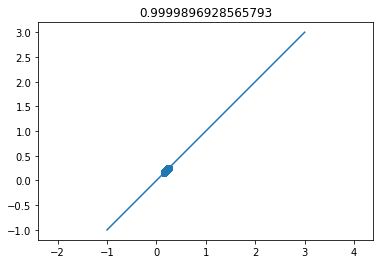

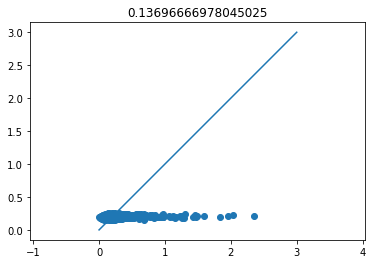

In [17]:
y_R, y_matlab = test_gaussian(X_train_pca, y_train)

In [18]:
# first, do Gaussian.
def test_softplus(X, y):
    with Timer('Gaussian R'):
        fit_R = glm.glmnet_cv(X, y, standardize=False, type_measure='mse',
                            family='gaussian',
                            foldid=foldid, alpha=1.0, keep=True)
        predicted_y_R = glm.glmnet_extract_preval(fit_R, 'lambda.min')
#     print(np.array(fit_R.rx2('lambda')), predicted_y_R.shape)
    
    # then let's use default value of matlab
    with Timer('softplus MATLAB'):
        predicted_y_matlab, fit_matlab = glm_matlab.glmnet_cv_best_result(X,y,standardize=False,
                            family='softplus',foldid=foldid, alpha=1.0, debug=True)
#     print(fit_matlab['FitInfo']['Lambda'], predicted_y_matlab.shape)
#     predicted_y_R, predicted_y_matlab

    
    # check their lambda
    print(np.array(fit_R.rx2('lambda')),
          fit_matlab['FitInfo']['Lambda'][0,0].ravel()[::-1])
    # check their deviance
    print(np.array(fit_R.rx2('cvm')),
          fit_matlab['FitInfo']['Deviance'][0,0].ravel()[::-1]/1000)
    
    plt.close()
    plt.figure()
    plt.scatter(predicted_y_R, predicted_y_matlab)
    plt.title(f'{pearsonr(predicted_y_R, predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([-1,3],[-1,3])
    plt.show()
    
    
    plt.close()
    plt.figure()
    plt.scatter(y, predicted_y_matlab)
    plt.title(f'{pearsonr(y.ravel(), predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([0,3],[0,3])
    plt.show()
    return predicted_y_R, predicted_y_matlab

[Gaussian R] Elapsed: 5.773368835449219

                            < M A T L A B (R) >
                  Copyright 1984-2016 The MathWorks, Inc.
                   R2016b (9.1.0.441655) 64-bit (glnxa64)
                             September 7, 2016

 
To get started, type one of these: helpwin, helpdesk, or demo.
For product information, visit www.mathworks.com.
 
>> >> >> >> >> >> new CV
>> >> 
[softplus MATLAB] Elapsed: 836.0217204093933
[  1.56812570e-02   1.42881774e-02   1.30188551e-02   1.18622959e-02
   1.08084822e-02   9.84828644e-03   8.97339181e-03   8.17622041e-03
   7.44986753e-03   6.78804183e-03   6.18501090e-03   5.63555158e-03
   5.13490471e-03   4.67873393e-03   4.26308810e-03   3.88436710e-03
   3.53929064e-03   3.22486981e-03   2.93838126e-03   2.67734357e-03
   2.43949575e-03   2.22277767e-03   2.02531223e-03   1.84538907e-03
   1.68144979e-03   1.53207443e-03   1.39596916e-03   1.27195510e-03
   1.15895812e-03   1.05599947e-03   9.62187391e-04   8.76709315e-04
 

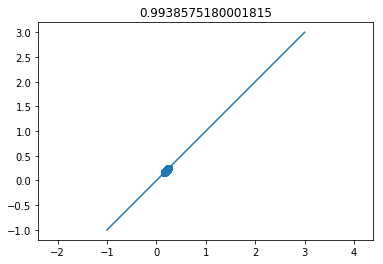

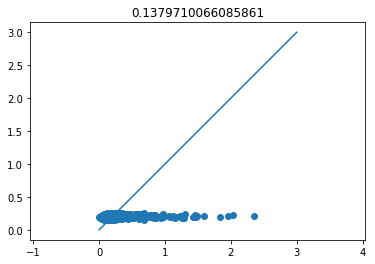

In [19]:
y_R, y_matlab = test_softplus(X_train_pca, y_train)

In [20]:
# first, do Gaussian.
def test_poisson(X, y):
    with Timer('poisson R'):
        fit_R = glm.glmnet_cv(X, y, standardize=False, type_measure='deviance',
                            family='poisson',
                            foldid=foldid, alpha=1.0, keep=True)
        predicted_y_R = glm.glmnet_extract_preval(fit_R, 'lambda.min')
#     print(np.array(fit_R.rx2('lambda')), predicted_y_R.shape)
    
    # then let's use default value of matlab
    with Timer('poisson MATLAB'):
        predicted_y_matlab, fit_matlab = glm_matlab.glmnet_cv_best_result(X,y,standardize=False,
                            family='poisson',foldid=foldid, alpha=1.0, debug=True)
#     print(fit_matlab['FitInfo']['Lambda'], predicted_y_matlab.shape)
#     predicted_y_R, predicted_y_matlab

    
    # check their lambda
    print(np.array(fit_R.rx2('lambda')),
          fit_matlab['FitInfo']['Lambda'][0,0].ravel()[::-1])
    # check their deviance
    print(np.array(fit_R.rx2('cvm')),
          fit_matlab['FitInfo']['Deviance'][0,0].ravel()[::-1]/1000)
    
    plt.close()
    plt.figure()
    plt.scatter(np.exp(predicted_y_R), predicted_y_matlab)
    plt.title(f'{pearsonr(np.exp(predicted_y_R), predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([-1,3],[-1,3])
    plt.show()
    
    
    plt.close()
    plt.figure()
    plt.scatter(y, predicted_y_matlab)
    plt.title(f'{pearsonr(y.ravel(), predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([0,3],[0,3])
    plt.show()
    return predicted_y_R, predicted_y_matlab

[poisson R] Elapsed: 13.866532802581787

                            < M A T L A B (R) >
                  Copyright 1984-2016 The MathWorks, Inc.
                   R2016b (9.1.0.441655) 64-bit (glnxa64)
                             September 7, 2016

 
To get started, type one of these: helpwin, helpdesk, or demo.
For product information, visit www.mathworks.com.
 
>> >> >> >> >> >> new CV
>> >> 
[poisson MATLAB] Elapsed: 225.53727388381958
[  1.56812570e-02   1.42881774e-02   1.30188551e-02   1.18622959e-02
   1.08084822e-02   9.84828644e-03   8.97339181e-03   8.17622041e-03
   7.44986753e-03   6.78804183e-03   6.18501090e-03   5.63555158e-03
   5.13490471e-03   4.67873393e-03   4.26308810e-03   3.88436710e-03
   3.53929064e-03   3.22486981e-03   2.93838126e-03   2.67734357e-03
   2.43949575e-03   2.22277767e-03   2.02531223e-03   1.84538907e-03
   1.68144979e-03   1.53207443e-03   1.39596916e-03   1.27195510e-03
   1.15895812e-03   1.05599947e-03   9.62187391e-04   8.76709315e-04
 

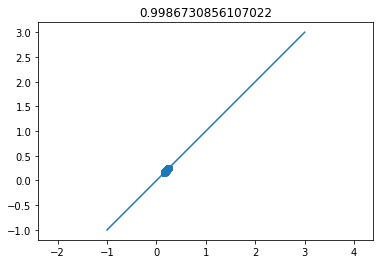

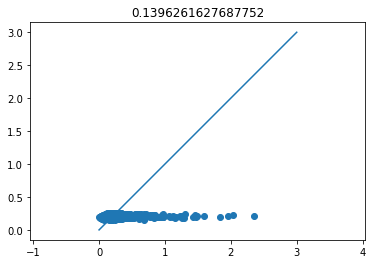

In [21]:
y_R, y_matlab = test_poisson(X_train_pca, y_train)